In [11]:
import pickle
X_hr,y_stress,y_participant,X_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia_normalized.p','rb'))

X_hr = X_hr.reshape(-1,30,1)
X_time.shape
np.concatenate([X_hr,X_time.reshape(-1,30,1)],axis=2)

(2149, 30, 2)

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib notebook
from keras.layers import Conv1D,Reshape,BatchNormalization,TimeDistributed, \
Dropout,Input,MaxPooling1D,Flatten,Dense,Input, GaussianNoise,LSTM, Bidirectional, Input
from keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer,LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances

train_participant = y_participant.copy()

train_x = X_hr
train_y = y_participant

train_x, test_x, train_y, test_y,participant_ids_train, participant_ids_test = train_test_split(X_hr,
                                                            train_participant,
                                                            y_participant,
                                                            test_size = 0.2,
                                                            random_state=41,
                                                            stratify=y_participant)
train_x, val_x, train_y, val_y, participant_ids_train, participant_ids_val  = train_test_split(train_x,
                                                            train_y,
                                                            participant_ids_train,
                                                            test_size = 0.1,
                                                            random_state=41,
                                                            stratify=participant_ids_train)

def custom_loss(embeddings):
    def loss(y_true,y_pred):
        return tf.keras.losses.SparseCategoricalCrossentropy(y_true,y_pred)
    return loss


def get_model(input_shape=(30,1),act='relu',loss="categorical_crossentropy",opt='adam',
              n_classes=350,n_output = 15):
    
    model =  Sequential()
    model.add(Input(shape=input_shape))
    model.add(Reshape(input_shape))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='linear',kernel_initializer='normal',padding='same'))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(200,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(300,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Conv1D(50,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(n_classes//2,activation=None))
    model.add(Dense(n_classes,activation=None))
    model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1),name='feature'))
    model.compile(loss=tfa.losses.TripletSemiHardLoss(),optimizer=opt)
    return model

n_classes = 200
n_output = len(np.unique(y_participant))
model = get_model(input_shape=(30,1),n_classes=n_classes,n_output=n_output) 
model.summary()

# model.layers[0]

from keras.models import load_model
filepath = '../model_files/base_cnn_60_seconds_ppg_hr_wesad_only_embeddings.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=40)
callbacks_list = [es,checkpoint]
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=400, 
                    batch_size=500,callbacks=callbacks_list,shuffle=True)

# # # model = load_model(filepath)

4 Physical GPUs, 1 Logical GPU
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 30, 1)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30, 100)           1100      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 30, 100)           100100    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 100)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 100)           400       
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)      

In [3]:
test_embeddings = model.predict(test_x)
# test_y_pred = model.predict(test_x)[0].argmax(axis=1)

In [4]:
from sklearn.metrics import confusion_matrix,classification_report

In [5]:
# print(classification_report(test_y,test_y_pred))

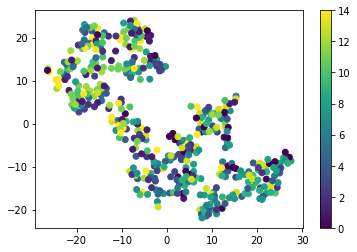

In [6]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
train_embeddings_pca = TSNE(n_components=2).fit_transform(test_embeddings)
plt.figure()
plt.scatter(train_embeddings_pca[:,0],train_embeddings_pca[:,1],c=test_y)
plt.colorbar()
plt.show()

In [ ]:
import pickle
test_dalia_x,test_dalia_y_stress,test_dalia_y,test_dalia_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia_normalized.p',
                                                                                 'rb'))

In [ ]:
test_dalia_x = test_dalia_x.reshape(-1,30,1)

In [ ]:
test_dalia_embeddings = model.predict(test_dalia_x)

In [ ]:
train_embeddings_pca = TSNE(n_components=2).fit_transform(test_dalia_embeddings)
plt.figure()
plt.scatter(train_embeddings_pca[:,0],train_embeddings_pca[:,1],c=test_dalia_y)
plt.colorbar()
plt.show()

In [ ]:
model = get_model(input_shape=(30,1),n_classes=n_classes,n_output=n_output,loss=custom_loss) 
model.summary()
model.load_weights(filepath)

In [ ]:
y_pred = model.predict(test_x).argmax(axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(confusion_matrix(test_y,y_pred))

In [ ]:
%matplotlib inline
def get_clusters(model,train_x,train_y):
    train_embeddings = model.predict(train_x)

    from sklearn.decomposition import PCA

    train_embeddings_pca = PCA(n_components=20).fit_transform(train_embeddings)

    plt.figure()
    plt.scatter(train_embeddings_pca[:,0],train_embeddings_pca[:,1],c=train_y)
    plt.show()
get_clusters(model,test_x,test_y)

In [ ]:
import pickle
test_dalia_x,test_dalia_y_stress,test_dalia_y,test_dalia_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia.p',
                                                                                 'rb'))
test_dalia_x = test_dalia_x.reshape(-1,30,1)
get_clusters(model,test_dalia_x,test_dalia_y)

In [ ]:
def give_rank_accuracy(train_embeddings,train_y,rank = 10):
    distance_matrix = euclidean_distances(train_embeddings)
    distance_matrix_2d = np.zeros((distance_matrix.shape[0],
                               distance_matrix.shape[0],
                               2))
    distance_matrix_2d[:,:,0] = distance_matrix
    train_y_matrix = np.concatenate([train_y.reshape(1,-1)]*distance_matrix.shape[0])
    distance_matrix_2d[:,:,1] = train_y_matrix
    match = 0
    for i in range(distance_matrix.shape[0]):
        row = distance_matrix_2d[i]
        row = row[row[:,0].argsort(),:]
        if rank==1:
            if train_y[i]==row[1,1]:
                match+=1
        else:
            row = set(row[1:(rank+1)][:,1])
            if train_y[i] in row:
                match+=1
    return match/distance_matrix.shape[0]

In [ ]:
rank_1 = give_rank_accuracy(train_embeddings,train_y,rank = 1)
rank_5 = give_rank_accuracy(train_embeddings,train_y,rank = 5)
rank_10 = give_rank_accuracy(train_embeddings,train_y,rank = 10)
print(rank_1,rank_5,rank_10)

In [ ]:
test_embeddings = model.predict(test_x)

In [ ]:
rank_1 = give_rank_accuracy(test_embeddings,test_y,rank = 1)
rank_5 = give_rank_accuracy(test_embeddings,test_y,rank = 5)
rank_10 = give_rank_accuracy(test_embeddings,test_y,rank = 10)
print(rank_1,rank_5,rank_10)

In [ ]:
test_x,y_stress,test_y,X_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr_dalia.p','rb'))

In [ ]:
test_x = test_x.reshape(-1,30,1)

In [ ]:
test_embeddings = model.predict(test_x)
rank_1 = give_rank_accuracy(test_embeddings,test_y,rank = 1)
rank_5 = give_rank_accuracy(test_embeddings,test_y,rank = 5)
rank_10 = give_rank_accuracy(test_embeddings,test_y,rank = 10)
print(rank_1,rank_5,rank_10)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(train_y,train_y_pred))
print(confusion_matrix(train_y,train_y_pred))